In [15]:
from gurobipy import *
import csv
import random
# import multidict
import numpy as np
import pandas as pd
import itertools
from itertools import permutations
import matplotlib.pyplot as plt
import math

In [60]:
def single_VRS_model(single_data):

    DMU, X, Y = single_data
    feasible = [False for i in range(len(DMU))]

    E = {}
    for r in DMU:
        try:
            # number of stage
            K = 3
            H = K

            e = 1
            # number of DMU
            N = len(DMU)

            m_k = [1, 1, 1]
            r_k = [1, 1, 1]

            w = [1/3, 1/3, 1/3]

            m = Model("model")
            m.setParam('OutputFlag', False)  # Muting the optimize function

            # add variables
            λ   = m.addVars(N, K, lb=0, vtype=GRB.CONTINUOUS, name="λ_") # λ_jk
            w_j = m.addVars(N, K, lb=0, vtype=GRB.CONTINUOUS, name="w_j_")

            s_neg = m.addVars(N, 5, lb=0, vtype=GRB.CONTINUOUS, name="s_neg_")
            s_pos = m.addVars(N, K, lb=0, vtype=GRB.CONTINUOUS, name="s_pos_")


            #  set Objective
            m.setObjective(quicksum(w[k] * (1- (s_neg[r, k] / X[r][k])) for k in range(K)), GRB.MINIMIZE)


            # add Constrs
            for k in range(K):
                m.addConstr(sum(e * λ[j, k] for j in range(N)) == 1, "C3")
                m.addConstr(sum(w_j[j, k] for j in range(N)) == 1, "C4")

            # k=0
            m.addConstr((X[r][0] == sum(X[j][0] * λ[j, 0] + s_neg[r, 0] for j in range(N))), "C1") #  input: X1
            m.addConstr((Y[r][0] == sum(Y[j][0] * λ[j, 0] - s_pos[r, 0] for j in range(N))), "C2") # output: Y1(z2)
        
            # k=1
            m.addConstr((X[r][1] == sum(X[j][1] * λ[j, 1] + s_neg[r, 1] for j in range(N))), "C3") #  input: X2
            m.addConstr((Y[r][1] == sum(Y[j][0] * λ[j, 1] + s_neg[r, 3] for j in range(N))), "C4") #  input: Y1(z1)
            m.addConstr((Y[r][1] == sum(Y[j][1] * λ[j, 1] - s_pos[r, 1] for j in range(N))), "C5") # output: Y2(z2)

            # k=2
            m.addConstr((X[r][2] == sum(X[j][2] * λ[j, 2] + s_neg[r, 2] for j in range(N))), "C6") #  input: X3
            m.addConstr((Y[r][2] == sum(Y[j][2] * λ[j, 2] + s_neg[r, 4] for j in range(N))), "C7") #  input: Y2(z2)
            m.addConstr((Y[r][2] == sum(Y[j][2] * λ[j, 2] - s_pos[r, 2] for j in range(N))), "C8") # output: Y3

            # (k, h) pairs
            # z[j ,0, 1] = Y[j, 0]
            m.addConstr(((sum(Y[j][0] * λ[j, 0] for j in range(N)) - sum(Y[j][0] * λ[j, 1] for j in range(N))) <= 0.1), "C5-1")
            # z[j ,1, 2] = Y[j, 1]
            m.addConstr((sum(Y[j][1] * λ[j, 1] for j in range(N)) - sum(Y[j][1] * λ[j, 2] for j in range(N)) <= 0.1), "C5-2")

            m.optimize()
            
            if m.Status == 2:
                # Store the result
                E[r] =  m.objVal
                feasible[r] = True
            else:
                E[r] = m.Status
            
        except GurobiError:
            E[r] = 'GurobiError reported'

    # return E, feasible
    return list(E.values()), feasible

In [61]:
def single_CRS_model(single_data):

    DMU, X, Y = single_data
    feasible = [False for i in range(len(DMU))]

    E = {}
    for r in DMU:
        try:
            # number of stage
            K = 3
            H = K

            # number of DMU
            N = len(DMU)

            m_k = [1, 1, 1]
            r_k = [1, 1, 1]

            w = [1/3, 1/3, 1/3]

            m = Model("model")
            m.setParam('OutputFlag', False)  # Muting the optimize function

            # add variables
            λ   = m.addVars(N, K, lb=0, vtype=GRB.CONTINUOUS, name="λ_") # λ_jk
            w_j = m.addVars(N, K, lb=0, vtype=GRB.CONTINUOUS, name="w_j_")

            s_neg = m.addVars(N, 5, lb=0, vtype=GRB.CONTINUOUS, name="s_neg_")
            s_pos = m.addVars(N, K, lb=0, vtype=GRB.CONTINUOUS, name="s_pos_")


            #  set Objective
            m.setObjective(quicksum(w[k] * (1- (s_neg[r, k] / X[r][k])) for k in range(K)), GRB.MINIMIZE)


            # add Constrs
            for k in range(K):
                # m.addConstr(sum(e * λ[j, k] for j in range(N)) == 1, "C3")
                m.addConstr(sum(w_j[j, k] for j in range(N)) == 1, "C4")

            # k=0
            m.addConstr((X[r][0] == sum(X[j][0] * λ[j, 0] + s_neg[r, 0] for j in range(N))), "C1") #  input: X1
            m.addConstr((Y[r][0] == sum(Y[j][0] * λ[j, 0] - s_pos[r, 0] for j in range(N))), "C2") # output: Y1(z2)
        
            # k=1
            m.addConstr((X[r][1] == sum(X[j][1] * λ[j, 1] + s_neg[r, 1] for j in range(N))), "C3") #  input: X2
            m.addConstr((Y[r][1] == sum(Y[j][0] * λ[j, 1] + s_neg[r, 3] for j in range(N))), "C4") #  input: Y1(z1)
            m.addConstr((Y[r][1] == sum(Y[j][1] * λ[j, 1] - s_pos[r, 1] for j in range(N))), "C5") # output: Y2(z2)

            # k=2
            m.addConstr((X[r][2] == sum(X[j][2] * λ[j, 2] + s_neg[r, 2] for j in range(N))), "C6") #  input: X3
            m.addConstr((Y[r][2] == sum(Y[j][2] * λ[j, 2] + s_neg[r, 4] for j in range(N))), "C7") #  input: Y2(z2)
            m.addConstr((Y[r][2] == sum(Y[j][2] * λ[j, 2] - s_pos[r, 2] for j in range(N))), "C8") # output: Y3

            # (k, h) pairs
            # z[j ,0, 1] = Y[j, 0]
            m.addConstr(((sum(Y[j][0] * λ[j, 0] for j in range(N)) - sum(Y[j][0] * λ[j, 1] for j in range(N))) <= 0.1), "C5-1")
            # z[j ,1, 2] = Y[j, 1]
            m.addConstr((sum(Y[j][1] * λ[j, 1] for j in range(N)) - sum(Y[j][1] * λ[j, 2] for j in range(N)) <= 0.1), "C5-2")

            m.optimize()
            
            if m.Status == 2:
                # Store the result
                E[r] =  m.objVal
                feasible[r] = True
            else:
                E[r] = m.Status
            
        except GurobiError:
            E[r] = 'GurobiError reported'

    # return E, feasible
    return list(E.values()), feasible

In [62]:
def single_VRS(single_data):

    DMU, X, Y = single_data
    I = len(X[0])
    O = len(Y[0])
    feasible = [False for i in range(len(DMU))]
    E = {}
    for h in DMU:
        try:
            # The decision variables
            theta, λ, Sr, Si = {}, {}, {}, {}
            # Initialize LP model
            m = Model("Dual_of_VRS_model")
            m.setParam('OutputFlag', False)  # Muting the optimize function
            
            # Add decision variables
            for r in DMU:
                λ[r]     = m.addVar(vtype=GRB.CONTINUOUS, name="λ_%s" % r)
                theta[h] = m.addVar(vtype=GRB.CONTINUOUS, lb=-1000, name="theta_%s" % h)
                Si[h]    = m.addVars(I, lb=0, vtype=GRB.CONTINUOUS, name="Si_%s" % h)
                Sr[h]    = m.addVars(O, lb=0, vtype=GRB.CONTINUOUS, name="Sr_%s" % h)

            m.update()
            # Add objective function
            m.setObjective(theta[h] - epsilon * (sum(Si[h][i] + Si[h][i] for i in range(I))), GRB.MINIMIZE)

            # Add constraints
            # for each input
            for i in range(I):
                m.addConstr(quicksum(λ[j]*X[j][i] for j in DMU) + Si[h][i] == theta[h]*X[h][i])
            # for each output
            for r in range(O):
                m.addConstr(quicksum(λ[j]*Y[j][r] for j in DMU) - Sr[h][r] >= Y[h][r])

            # turn on is VRS
            m.addConstr(sum(λ[j] for j in DMU) == 1) 
            
            # Start optimize the formulation
            m.optimize()
            # Store the result
            E[h] = m.objVal
            # E[h] = "The efficiency of DMU %s:%0.3f" % (h, m.objVal)
        
        except GurobiError:
            continue
            # print('GurobiError reported')
        # Print efficiency
            
    # return E
    return list(E.values())

In [112]:
def single_CRS(single_data):

    DMU, X, Y = single_data
    I = len(X[0])
    O = len(Y[0])
    feasible = [False for i in range(len(DMU))]
    E = {}
    for h in DMU:
        try:
            # The decision variables
            theta, λ, Sr, Si = {}, {}, {}, {}
            # Initialize LP model
            m = Model("Dual_of_CRS_model")
            m.setParam('OutputFlag', False)  # Muting the optimize function
            
            # Add decision variables
            for r in DMU:
                λ[r]     = m.addVar(vtype=GRB.CONTINUOUS, name="λ_%s" % r)
                theta[h] = m.addVar(vtype=GRB.CONTINUOUS, lb=-1000, name="theta_%s" % h)
                Si[h]    = m.addVars(I, lb=0, vtype=GRB.CONTINUOUS, name="Si_%s" % h)
                Sr[h]    = m.addVars(O, lb=0, vtype=GRB.CONTINUOUS, name="Sr_%s" % h)

            m.update()
            # Add objective function
            m.setObjective(theta[h] - epsilon * (sum(Si[h][i] + Si[h][i] for i in range(I))), GRB.MINIMIZE)

            # Add constraints
            # for each input
            for i in range(I):
                m.addConstr(quicksum(λ[j]*X[j][i] for j in DMU) + Si[h][i] == theta[h]*X[h][i])
            # for each output
            for r in range(O):
                m.addConstr(quicksum(λ[j]*Y[j][r] for j in DMU) - Sr[h][r] >= Y[h][r])

            # turn on is VRS
            # m.addConstr(sum(λ[j] for j in DMU) == 1) 
            
            # Start optimize the formulation
            m.optimize()
            # Store the result
            E[h] = m.objVal
            # E[h] = "The efficiency of DMU %s:%0.3f" % (h, m.objVal)
        
        except GurobiError:
            continue
            # print('GurobiError reported')
        # Print efficiency
        print(λ)
        
    # return E
    
        
    return list(E.values())

In [64]:
def input_generator(idx):
    # INPUT
    age = random.randint(1, 179)
    risk = random.randint(1, 50)
    size = random.randint(5000, 9999) # 5000–9999
    returns = [age, risk, size]

    # return INPUT
    return float(returns[idx])
    # return [float(age), float(risk), float(size)]


def output_generator():
    # OUTPUT
    # 0.5 bn to 1 bn
    sale = random.randint(5, 10)

    # return OUTPUT
    return float(sale)

input_generator(1), output_generator()

(36.0, 7.0)

In [65]:
def dataset_generate(N, type, input_idx):
    ## Data generator

    K = 3
    X, Y = {}, {}
    DMU = []

    for j in range(N):
        DMU.append(j)
        X[j] = {}
        Y[j] = {}
        if type == "SD":
            same_input = input_generator(input_idx)
            for k in range(K):
                X[j][k] = same_input
                Y[j][k] = output_generator()
                    
        elif type == "DS":
            same_output = output_generator()
            for k in range(K):
                X[j][k] = input_generator(input_idx)
                Y[j][k] = same_output

        elif type == "DD":
            for k in range(K):
                X[j][k] = input_generator(input_idx)
                Y[j][k] = output_generator()

    return DMU, X, Y

In [67]:
def plot_fig(model_result:list, crs_result:list):
    plt.figure()
    plt.plot(model_result, crs_result, 'bo')
    plt.xlabel('model_result')
    plt.ylabel('crs_result')

    plt.xlim([0,1.1])
    plt.ylim([0,1.1])
    plt.show()

## TEST

1/2{0: <gurobi.Var λ_0 (value 0.0)>, 1: <gurobi.Var λ_1 (value 0.0)>, 2: <gurobi.Var λ_2 (value 1.0973812214415566)>, 3: <gurobi.Var λ_3 (value 0.0)>, 4: <gurobi.Var λ_4 (value 0.42696408391883256)>}
{0: <gurobi.Var λ_0 (value 0.0)>, 1: <gurobi.Var λ_1 (value 0.0)>, 2: <gurobi.Var λ_2 (value 0.46441395491176174)>, 3: <gurobi.Var λ_3 (value 0.4355860450882383)>, 4: <gurobi.Var λ_4 (value 0.0)>}
{0: <gurobi.Var λ_0 (value 0.0)>, 1: <gurobi.Var λ_1 (value 0.0)>, 2: <gurobi.Var λ_2 (value 1.0)>, 3: <gurobi.Var λ_3 (value 0.0)>, 4: <gurobi.Var λ_4 (value 0.0)>}
{0: <gurobi.Var λ_0 (value 0.0)>, 1: <gurobi.Var λ_1 (value 0.0)>, 2: <gurobi.Var λ_2 (value 0.0)>, 3: <gurobi.Var λ_3 (value 1.0)>, 4: <gurobi.Var λ_4 (value 0.0)>}
{0: <gurobi.Var λ_0 (value 0.0)>, 1: <gurobi.Var λ_1 (value 0.0)>, 2: <gurobi.Var λ_2 (value 0.0)>, 3: <gurobi.Var λ_3 (value 0.0)>, 4: <gurobi.Var λ_4 (value 1.0)>}
[0, 1, 2, 3, 4] {0: {0: 167.0, 1: 103.0, 2: 72.0}, 1: {0: 89.0, 1: 106.0, 2: 125.0}, 2: {0: 32.0, 1: 81.0

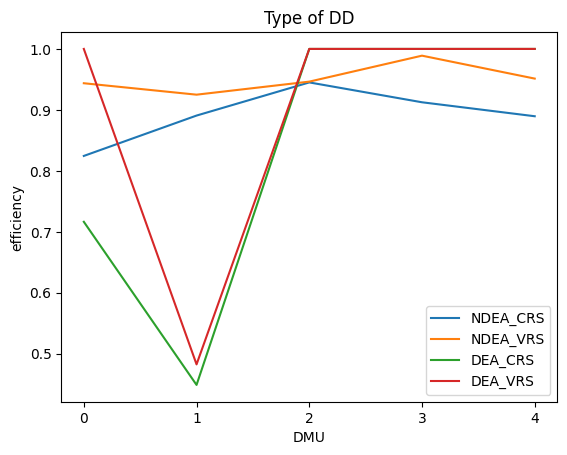

2/2{0: <gurobi.Var λ_0 (value 1.0)>, 1: <gurobi.Var λ_1 (value 0.0)>, 2: <gurobi.Var λ_2 (value 0.0)>, 3: <gurobi.Var λ_3 (value 0.0)>, 4: <gurobi.Var λ_4 (value 0.0)>}
{0: <gurobi.Var λ_0 (value 0.0)>, 1: <gurobi.Var λ_1 (value 1.0)>, 2: <gurobi.Var λ_2 (value 0.0)>, 3: <gurobi.Var λ_3 (value 0.0)>, 4: <gurobi.Var λ_4 (value 0.0)>}
{0: <gurobi.Var λ_0 (value 0.0)>, 1: <gurobi.Var λ_1 (value 0.0)>, 2: <gurobi.Var λ_2 (value 1.0)>, 3: <gurobi.Var λ_3 (value 0.0)>, 4: <gurobi.Var λ_4 (value 0.0)>}
{0: <gurobi.Var λ_0 (value 0.15394094740474196)>, 1: <gurobi.Var λ_1 (value 0.0)>, 2: <gurobi.Var λ_2 (value 0.863163602306896)>, 3: <gurobi.Var λ_3 (value 0.0)>, 4: <gurobi.Var λ_4 (value 0.0)>}
{0: <gurobi.Var λ_0 (value 0.6209590136934733)>, 1: <gurobi.Var λ_1 (value 0.0)>, 2: <gurobi.Var λ_2 (value 0.3369253211613571)>, 3: <gurobi.Var λ_3 (value 0.0)>, 4: <gurobi.Var λ_4 (value 0.0)>}
[0, 1, 2, 3, 4] {0: {0: 67.0, 1: 24.0, 2: 66.0}, 1: {0: 172.0, 1: 77.0, 2: 25.0}, 2: {0: 21.0, 1: 138.0, 2:

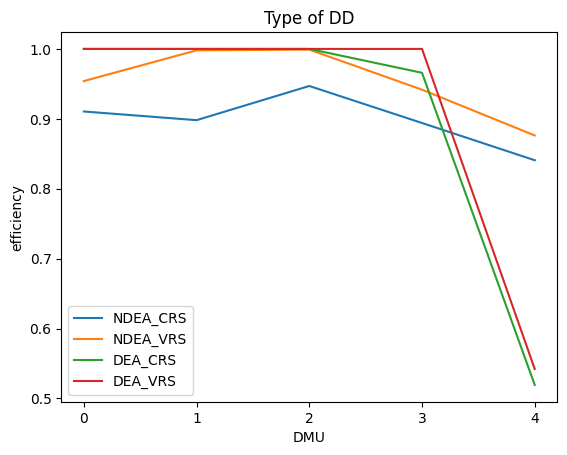

In [114]:
def rounding(a_list, dit=3):
    return list(map(lambda x: round(x, dit), a_list))

# Setting

passing_dataset = []
passing_result = {}
total = 2
epsilon = 0.001

setting_type = "DD"
# random generate the pass dataset
while len(passing_dataset) < total:
    idx = len(passing_dataset)

    # model_result, label = single_model(temp:=dataset_generate_trend(N=5, type="DD", input_idx=0))
    model_CRS_result, label_CRS = single_CRS_model(temp:=dataset_generate(N=5, type=setting_type, input_idx=0))
    model_VRS_result, label_VRS = single_VRS_model(temp)
    # print(temp)
    # print(model_result)
    
    if all(x == True for x in label_CRS +label_VRS):
        print(f"\r{idx+1}/{total}", end='')
        CRS_result = single_CRS(temp)
        VRS_result = single_VRS(temp)

        # store the results
        passing_dataset.append(temp)
        passing_result[idx] = {}
        passing_result[idx]["model_CRS"] = rounding(model_CRS_result)
        passing_result[idx]["model_VRS"] = rounding(model_VRS_result)
        passing_result[idx]["CRS"]   = rounding(CRS_result)
        passing_result[idx]["VRS"]   = rounding(VRS_result)

        print(temp[0], temp[1], temp[2])
        print('model_CRS_result', rounding(model_CRS_result))
        print('model_VRS_result', rounding(model_VRS_result))
        print('CRS_result', rounding(CRS_result))
        print('VRS_result', rounding(VRS_result))

        result = {'NDEA_CRS':rounding(model_CRS_result),
                  'NDEA_VRS': rounding(model_VRS_result),
                  'DEA_CRS': rounding(CRS_result),
                  "DEA_VRS": rounding(VRS_result)
        }
        rusult_name = ['model_CRS_result','model_VRS_result', 'CRS_result', 'VRS_result']
        

        # print(rusult_name)
        plt.plot(model_CRS_result, label="NDEA_CRS")
        plt.plot(model_VRS_result, label="NDEA_VRS")
        plt.plot(CRS_result, label="DEA_CRS")
        plt.plot(VRS_result, label="DEA_VRS")
        plt.xlabel('DMU')
        
        plt.ylabel('efficiency')
        plt.xticks([0,1,2,3,4])
        # plt.xticks(model_CRS_result, ['1', '2','3', '4'], rotation ='vertical') 
        plt.legend()
        plt.title(f"Type of {setting_type}")
        plt.show()
        plt.close()

        # plot_lines(result,
        #            rusult_name=rusult_name,
        #            setting_type=setting_type)


# store the result to txt or other files
# passing_dataset

1/5[0, 1, 2, 3, 4] {0: {0: 65.0, 1: 158.0, 2: 108.0}, 1: {0: 124.0, 1: 54.0, 2: 8.0}, 2: {0: 170.0, 1: 63.0, 2: 170.0}, 3: {0: 71.0, 1: 108.0, 2: 108.0}, 4: {0: 101.0, 1: 26.0, 2: 87.0}} {0: {0: 7.0, 1: 9.0, 2: 10.0}, 1: {0: 5.0, 1: 9.0, 2: 10.0}, 2: {0: 5.0, 1: 7.0, 2: 10.0}, 3: {0: 8.0, 1: 8.0, 2: 7.0}, 4: {0: 5.0, 1: 10.0, 2: 6.0}}
model_CRS_result [0.9, 0.929, 0.852, 0.953, 0.961]
model_VRS_result [0.931, 0.966, 0.881, 0.973, 0.999]
CRS_result [1.0, 1.0, 0.538, 1.0, 1.0]
VRS_result [1.0, 1.0, 0.538, 1.0, 1.0]


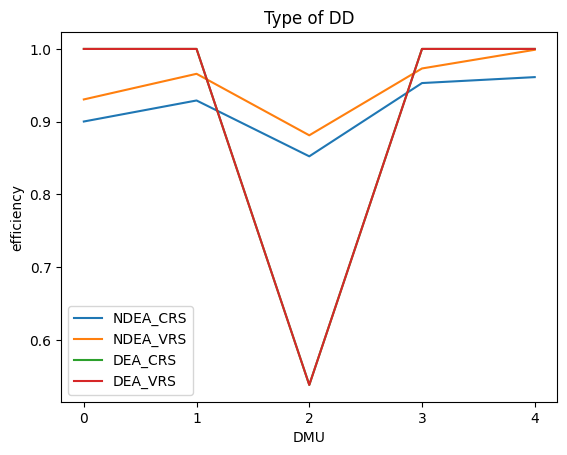

2/5[0, 1, 2, 3, 4] {0: {0: 102.0, 1: 87.0, 2: 95.0}, 1: {0: 131.0, 1: 125.0, 2: 75.0}, 2: {0: 32.0, 1: 131.0, 2: 172.0}, 3: {0: 12.0, 1: 22.0, 2: 63.0}, 4: {0: 171.0, 1: 80.0, 2: 164.0}} {0: {0: 6.0, 1: 10.0, 2: 9.0}, 1: {0: 7.0, 1: 8.0, 2: 7.0}, 2: {0: 5.0, 1: 9.0, 2: 7.0}, 3: {0: 10.0, 1: 10.0, 2: 9.0}, 4: {0: 5.0, 1: 6.0, 2: 5.0}}
model_CRS_result [0.866, 0.868, 0.885, 1.0, 0.842]
model_VRS_result [0.869, 0.904, 0.916, 1.0, 0.944]
CRS_result [0.48, 0.382, 0.286, 1.0, 0.156]
VRS_result [0.48, 0.478, 0.318, 1.0, 0.259]


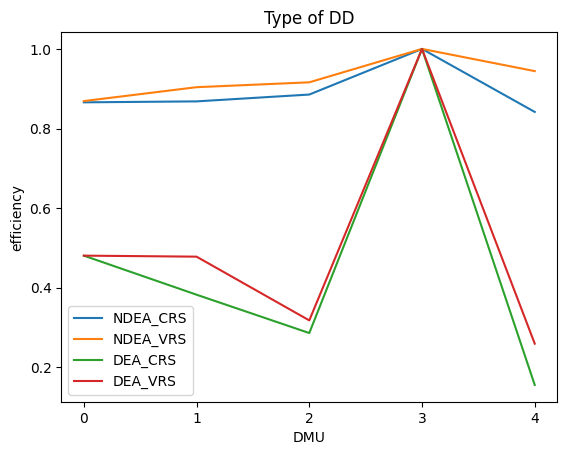

3/5[0, 1, 2, 3, 4] {0: {0: 80.0, 1: 75.0, 2: 25.0}, 1: {0: 74.0, 1: 23.0, 2: 42.0}, 2: {0: 113.0, 1: 84.0, 2: 136.0}, 3: {0: 80.0, 1: 105.0, 2: 169.0}, 4: {0: 59.0, 1: 52.0, 2: 15.0}} {0: {0: 6.0, 1: 9.0, 2: 8.0}, 1: {0: 6.0, 1: 6.0, 2: 8.0}, 2: {0: 5.0, 1: 7.0, 2: 9.0}, 3: {0: 5.0, 1: 9.0, 2: 8.0}, 4: {0: 5.0, 1: 8.0, 2: 10.0}}
model_CRS_result [0.955, 0.949, 0.863, 0.881, 0.973]
model_VRS_result [0.995, 0.973, 0.874, 0.907, 1.0]
CRS_result [0.869, 1.0, 0.423, 0.526, 1.0]
VRS_result [1.0, 1.0, 0.441, 0.652, 1.0]


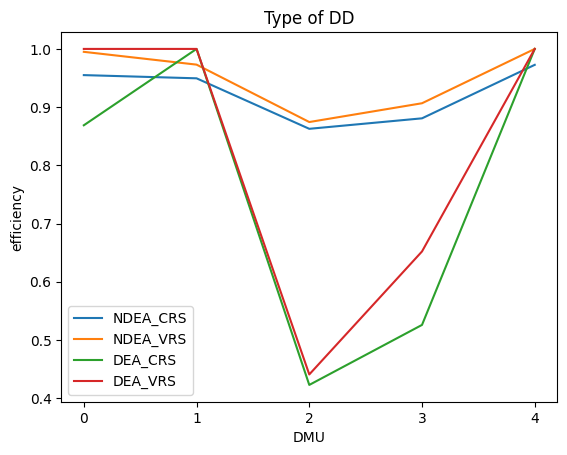

4/5[0, 1, 2, 3, 4] {0: {0: 81.0, 1: 123.0, 2: 75.0}, 1: {0: 10.0, 1: 46.0, 2: 4.0}, 2: {0: 107.0, 1: 114.0, 2: 110.0}, 3: {0: 152.0, 1: 52.0, 2: 33.0}, 4: {0: 74.0, 1: 111.0, 2: 176.0}} {0: {0: 5.0, 1: 7.0, 2: 9.0}, 1: {0: 7.0, 1: 7.0, 2: 5.0}, 2: {0: 7.0, 1: 10.0, 2: 10.0}, 3: {0: 7.0, 1: 9.0, 2: 8.0}, 4: {0: 8.0, 1: 8.0, 2: 9.0}}
model_CRS_result [0.834, 0.999, 0.845, 0.884, 0.844]
model_VRS_result [0.897, 1.0, 0.94, 0.938, 0.957]
CRS_result [0.514, 1.0, 0.513, 0.936, 0.423]
VRS_result [1.0, 1.0, 1.0, 1.0, 1.0]


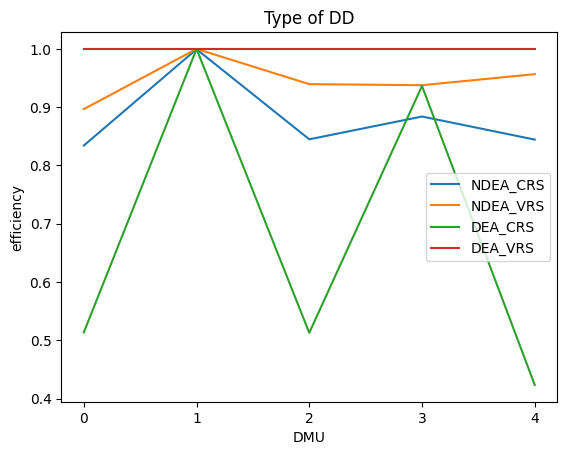

5/5[0, 1, 2, 3, 4] {0: {0: 146.0, 1: 41.0, 2: 22.0}, 1: {0: 92.0, 1: 137.0, 2: 98.0}, 2: {0: 161.0, 1: 165.0, 2: 170.0}, 3: {0: 19.0, 1: 91.0, 2: 76.0}, 4: {0: 170.0, 1: 85.0, 2: 38.0}} {0: {0: 7.0, 1: 8.0, 2: 6.0}, 1: {0: 10.0, 1: 10.0, 2: 8.0}, 2: {0: 5.0, 1: 9.0, 2: 7.0}, 3: {0: 8.0, 1: 8.0, 2: 5.0}, 4: {0: 6.0, 1: 7.0, 2: 10.0}}
model_CRS_result [0.941, 0.876, 0.834, 0.993, 0.898]
model_VRS_result [0.961, 0.998, 0.866, 0.994, 0.971]
CRS_result [1.0, 0.851, 0.486, 1.0, 1.0]
VRS_result [1.0, 1.0, 0.542, 1.0, 1.0]


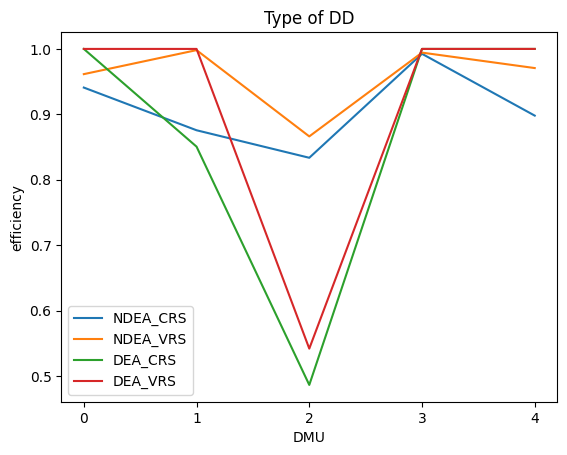

In [105]:
def rounding(a_list, dit=3):
    return list(map(lambda x: round(x, dit), a_list))

# Setting

passing_dataset = []
passing_result = {}
total = 5
epsilon = 0.001

setting_type = "DD"
# random generate the pass dataset
while len(passing_dataset) < total:
    idx = len(passing_dataset)

    # model_result, label = single_model(temp:=dataset_generate_trend(N=5, type="DD", input_idx=0))
    model_CRS_result, label_CRS = single_CRS_model(temp:=dataset_generate(N=5, type=setting_type, input_idx=0))
    model_VRS_result, label_VRS = single_VRS_model(temp)
    # print(temp)
    # print(model_result)
    
    if all(x == True for x in label_CRS +label_VRS):
        print(f"\r{idx+1}/{total}", end='')
        CRS_result = single_CRS(temp)
        VRS_result = single_VRS(temp)

        # store the results
        passing_dataset.append(temp)
        passing_result[idx] = {}
        passing_result[idx]["model_CRS"] = rounding(model_CRS_result)
        passing_result[idx]["model_VRS"] = rounding(model_VRS_result)
        passing_result[idx]["CRS"]   = rounding(CRS_result)
        passing_result[idx]["VRS"]   = rounding(VRS_result)

        print(temp[0], temp[1], temp[2])
        print('model_CRS_result', rounding(model_CRS_result))
        print('model_VRS_result', rounding(model_VRS_result))
        print('CRS_result', rounding(CRS_result))
        print('VRS_result', rounding(VRS_result))

        result = {'NDEA_CRS':rounding(model_CRS_result),
                  'NDEA_VRS': rounding(model_VRS_result),
                  'DEA_CRS': rounding(CRS_result),
                  "DEA_VRS": rounding(VRS_result)
        }
        rusult_name = ['model_CRS_result','model_VRS_result', 'CRS_result', 'VRS_result']
        

        # print(rusult_name)
        plt.plot(model_CRS_result, label="NDEA_CRS")
        plt.plot(model_VRS_result, label="NDEA_VRS")
        plt.plot(CRS_result, label="DEA_CRS")
        plt.plot(VRS_result, label="DEA_VRS")
        plt.xlabel('DMU')
        
        plt.ylabel('efficiency')
        plt.xticks([0,1,2,3,4])
        # plt.xticks(model_CRS_result, ['1', '2','3', '4'], rotation ='vertical') 
        plt.legend()
        plt.title(f"Type of {setting_type}")
        plt.show()
        plt.close()

        # plot_lines(result,
        #            rusult_name=rusult_name,
        #            setting_type=setting_type)


# store the result to txt or other files
# passing_dataset

## DS

1/5[0, 1, 2, 3, 4] {0: {0: 68.0, 1: 64.0, 2: 72.0}, 1: {0: 147.0, 1: 15.0, 2: 83.0}, 2: {0: 112.0, 1: 44.0, 2: 6.0}, 3: {0: 10.0, 1: 100.0, 2: 170.0}, 4: {0: 18.0, 1: 17.0, 2: 7.0}} {0: {0: 7.0, 1: 7.0, 2: 7.0}, 1: {0: 8.0, 1: 8.0, 2: 8.0}, 2: {0: 8.0, 1: 8.0, 2: 8.0}, 3: {0: 8.0, 1: 8.0, 2: 8.0}, 4: {0: 9.0, 1: 9.0, 2: 9.0}}
model_CRS_result [0.827, 0.876, 0.895, 0.879, 0.972]
model_VRS_result [0.994, 0.876, 0.895, 0.879, 1.0]
CRS_result [0.188, 0.588, 0.776, 0.779, 1.0]
VRS_result [0.241, 0.662, 0.873, 0.876, 1.0]


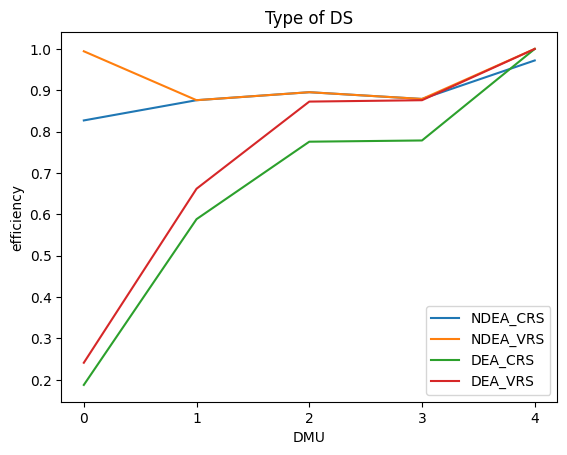

2/5[0, 1, 2, 3, 4] {0: {0: 52.0, 1: 177.0, 2: 114.0}, 1: {0: 92.0, 1: 50.0, 2: 178.0}, 2: {0: 146.0, 1: 99.0, 2: 21.0}, 3: {0: 66.0, 1: 115.0, 2: 100.0}, 4: {0: 172.0, 1: 126.0, 2: 178.0}} {0: {0: 10.0, 1: 10.0, 2: 10.0}, 1: {0: 10.0, 1: 10.0, 2: 10.0}, 2: {0: 7.0, 1: 7.0, 2: 7.0}, 3: {0: 6.0, 1: 6.0, 2: 6.0}, 4: {0: 5.0, 1: 5.0, 2: 5.0}}
model_CRS_result [0.903, 0.916, 0.907, 0.861, 0.829]
model_VRS_result [0.952, 0.947, 0.959, 0.997, 0.996]
CRS_result [1.0, 1.0, 1.0, 0.728, 0.344]
VRS_result [1.0, 1.0, 1.0, 1.0, 0.573]


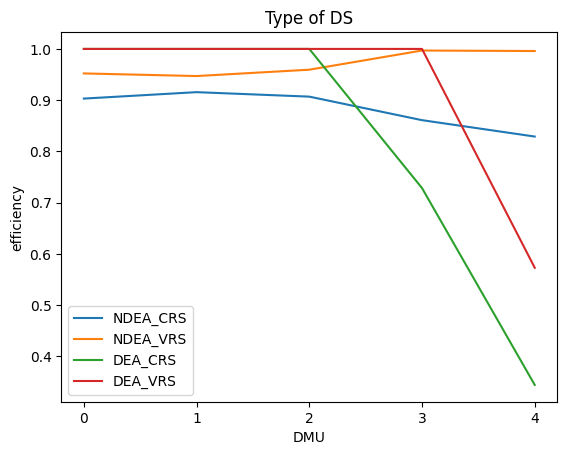

3/5[0, 1, 2, 3, 4] {0: {0: 25.0, 1: 114.0, 2: 134.0}, 1: {0: 22.0, 1: 119.0, 2: 79.0}, 2: {0: 88.0, 1: 56.0, 2: 73.0}, 3: {0: 68.0, 1: 164.0, 2: 121.0}, 4: {0: 152.0, 1: 44.0, 2: 14.0}} {0: {0: 7.0, 1: 7.0, 2: 7.0}, 1: {0: 6.0, 1: 6.0, 2: 6.0}, 2: {0: 9.0, 1: 9.0, 2: 9.0}, 3: {0: 10.0, 1: 10.0, 2: 10.0}, 4: {0: 9.0, 1: 9.0, 2: 9.0}}
model_CRS_result [0.892, 0.889, 0.89, 0.863, 0.947]
model_VRS_result [0.95, 1.0, 0.906, 1.0, 0.957]
CRS_result [1.0, 1.0, 1.0, 0.897, 1.0]
VRS_result [1.0, 1.0, 1.0, 1.0, 1.0]


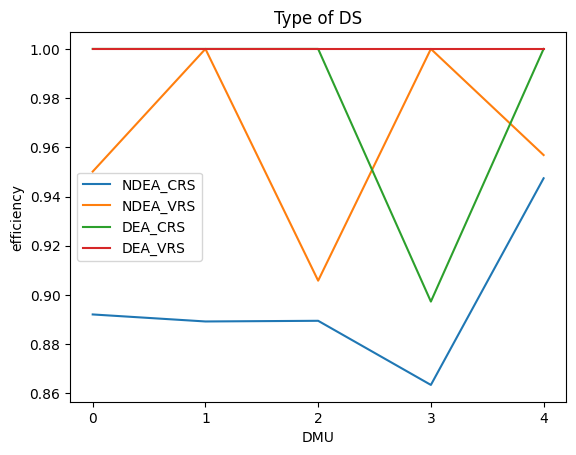

4/5[0, 1, 2, 3, 4] {0: {0: 30.0, 1: 103.0, 2: 8.0}, 1: {0: 2.0, 1: 52.0, 2: 133.0}, 2: {0: 50.0, 1: 141.0, 2: 116.0}, 3: {0: 83.0, 1: 22.0, 2: 122.0}, 4: {0: 80.0, 1: 45.0, 2: 87.0}} {0: {0: 9.0, 1: 9.0, 2: 9.0}, 1: {0: 6.0, 1: 6.0, 2: 6.0}, 2: {0: 8.0, 1: 8.0, 2: 8.0}, 3: {0: 10.0, 1: 10.0, 2: 10.0}, 4: {0: 7.0, 1: 7.0, 2: 7.0}}
model_CRS_result [0.886, 0.886, 0.816, 0.874, 0.83]
model_VRS_result [0.952, 1.0, 0.872, 1.0, 0.942]
CRS_result [1.0, 1.0, 0.493, 1.0, 0.714]
VRS_result [1.0, 1.0, 0.542, 1.0, 0.99]


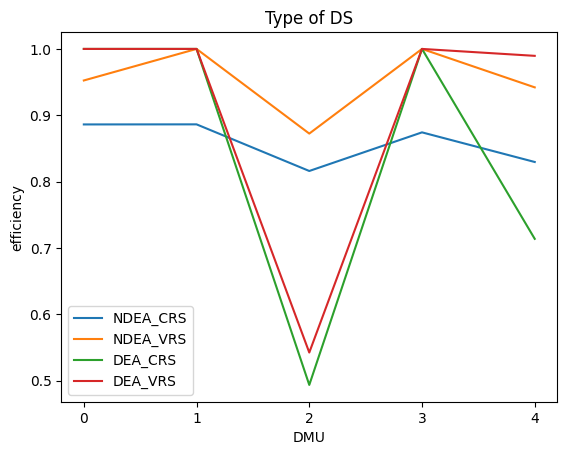

5/5[0, 1, 2, 3, 4] {0: {0: 11.0, 1: 97.0, 2: 139.0}, 1: {0: 128.0, 1: 130.0, 2: 172.0}, 2: {0: 4.0, 1: 114.0, 2: 32.0}, 3: {0: 66.0, 1: 71.0, 2: 152.0}, 4: {0: 55.0, 1: 141.0, 2: 24.0}} {0: {0: 5.0, 1: 5.0, 2: 5.0}, 1: {0: 8.0, 1: 8.0, 2: 8.0}, 2: {0: 7.0, 1: 7.0, 2: 7.0}, 3: {0: 6.0, 1: 6.0, 2: 6.0}, 4: {0: 5.0, 1: 5.0, 2: 5.0}}
model_CRS_result [0.869, 0.865, 0.982, 0.882, 0.895]
model_VRS_result [0.943, 1.0, 0.992, 0.886, 0.925]
CRS_result [0.639, 0.483, 1.0, 0.838, 0.748]
VRS_result [0.895, 1.0, 1.0, 0.978, 1.0]


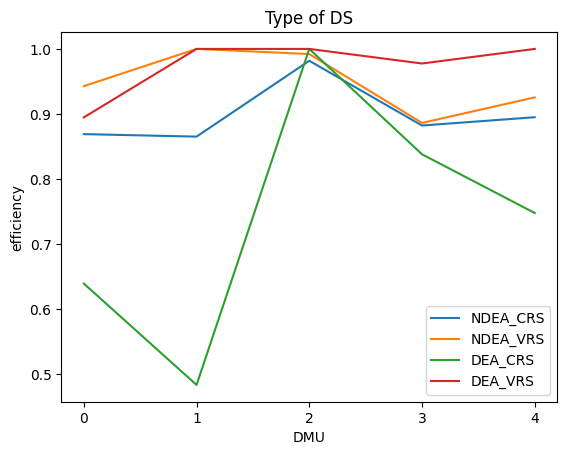

In [106]:
def rounding(a_list, dit=3):
    return list(map(lambda x: round(x, dit), a_list))

# Setting

passing_dataset = []
passing_result = {}
total = 5
epsilon = 0.001

setting_type = "DS"
# random generate the pass dataset
while len(passing_dataset) < total:
    idx = len(passing_dataset)

    # model_result, label = single_model(temp:=dataset_generate_trend(N=5, type="DD", input_idx=0))
    model_CRS_result, label_CRS = single_CRS_model(temp:=dataset_generate(N=5, type=setting_type, input_idx=0))
    model_VRS_result, label_VRS = single_VRS_model(temp)
    # print(temp)
    # print(model_result)
    
    if all(x == True for x in label_CRS +label_VRS):
        print(f"\r{idx+1}/{total}", end='')
        CRS_result = single_CRS(temp)
        VRS_result = single_VRS(temp)

        # store the results
        passing_dataset.append(temp)
        passing_result[idx] = {}
        passing_result[idx]["model_CRS"] = rounding(model_CRS_result)
        passing_result[idx]["model_VRS"] = rounding(model_VRS_result)
        passing_result[idx]["CRS"]   = rounding(CRS_result)
        passing_result[idx]["VRS"]   = rounding(VRS_result)

        print(temp[0], temp[1], temp[2])
        print('model_CRS_result', rounding(model_CRS_result))
        print('model_VRS_result', rounding(model_VRS_result))
        print('CRS_result', rounding(CRS_result))
        print('VRS_result', rounding(VRS_result))

        result = {'NDEA_CRS':rounding(model_CRS_result),
                  'NDEA_VRS': rounding(model_VRS_result),
                  'DEA_CRS': rounding(CRS_result),
                  "DEA_VRS": rounding(VRS_result)
        }
        rusult_name = ['model_CRS_result','model_VRS_result', 'CRS_result', 'VRS_result']
        

        # print(rusult_name)
        plt.plot(model_CRS_result, label="NDEA_CRS")
        plt.plot(model_VRS_result, label="NDEA_VRS")
        plt.plot(CRS_result, label="DEA_CRS")
        plt.plot(VRS_result, label="DEA_VRS")
        plt.xlabel('DMU')
        
        plt.ylabel('efficiency')
        plt.xticks([0,1,2,3,4])
        # plt.xticks(model_CRS_result, ['1', '2','3', '4'], rotation ='vertical') 
        plt.legend()
        plt.title(f"Type of {setting_type}")
        plt.show()
        plt.close()

        # plot_lines(result,
        #            rusult_name=rusult_name,
        #            setting_type=setting_type)


# store the result to txt or other files
# passing_dataset

## SD

1/5[0, 1, 2, 3, 4] {0: {0: 57.0, 1: 57.0, 2: 57.0}, 1: {0: 28.0, 1: 28.0, 2: 28.0}, 2: {0: 73.0, 1: 73.0, 2: 73.0}, 3: {0: 19.0, 1: 19.0, 2: 19.0}, 4: {0: 80.0, 1: 80.0, 2: 80.0}} {0: {0: 8.0, 1: 10.0, 2: 5.0}, 1: {0: 5.0, 1: 9.0, 2: 10.0}, 2: {0: 7.0, 1: 10.0, 2: 9.0}, 3: {0: 5.0, 1: 8.0, 2: 10.0}, 4: {0: 6.0, 1: 9.0, 2: 5.0}}
model_CRS_result [0.966, 0.958, 0.891, 1.0, 0.881]
model_VRS_result [1.0, 0.976, 0.955, 1.0, 0.902]
CRS_result [0.533, 0.763, 0.364, 1.0, 0.285]
VRS_result [1.0, 1.0, 1.0, 1.0, 0.433]


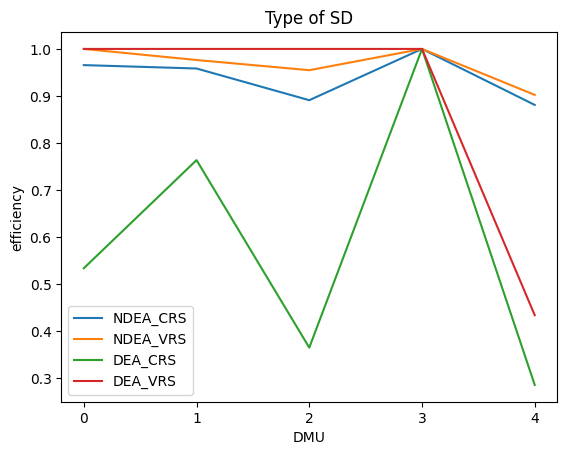

2/5[0, 1, 2, 3, 4] {0: {0: 118.0, 1: 118.0, 2: 118.0}, 1: {0: 144.0, 1: 144.0, 2: 144.0}, 2: {0: 133.0, 1: 133.0, 2: 133.0}, 3: {0: 113.0, 1: 113.0, 2: 113.0}, 4: {0: 6.0, 1: 6.0, 2: 6.0}} {0: {0: 9.0, 1: 10.0, 2: 6.0}, 1: {0: 6.0, 1: 8.0, 2: 10.0}, 2: {0: 7.0, 1: 10.0, 2: 10.0}, 3: {0: 5.0, 1: 7.0, 2: 5.0}, 4: {0: 6.0, 1: 10.0, 2: 6.0}}
model_CRS_result [0.872, 0.81, 0.812, 0.809, 1.0]
model_VRS_result [0.935, 0.867, 0.908, 0.986, 1.0]
CRS_result [0.076, 0.069, 0.075, 0.044, 1.0]
VRS_result [1.0, 0.924, 1.0, 0.053, 1.0]


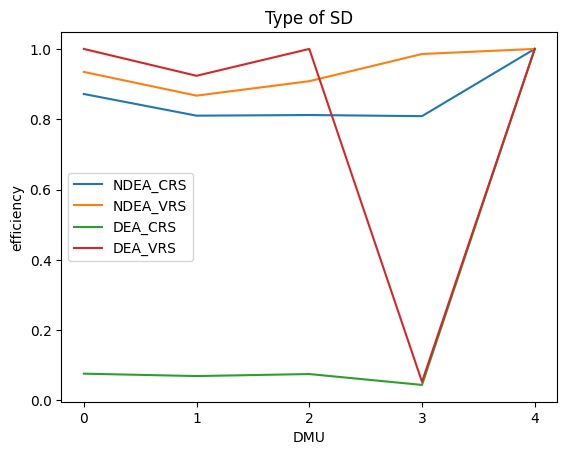

3/5[0, 1, 2, 3, 4] {0: {0: 76.0, 1: 76.0, 2: 76.0}, 1: {0: 94.0, 1: 94.0, 2: 94.0}, 2: {0: 55.0, 1: 55.0, 2: 55.0}, 3: {0: 72.0, 1: 72.0, 2: 72.0}, 4: {0: 149.0, 1: 149.0, 2: 149.0}} {0: {0: 8.0, 1: 10.0, 2: 5.0}, 1: {0: 5.0, 1: 7.0, 2: 6.0}, 2: {0: 6.0, 1: 10.0, 2: 5.0}, 3: {0: 5.0, 1: 9.0, 2: 6.0}, 4: {0: 5.0, 1: 10.0, 2: 6.0}}
model_CRS_result [0.978, 0.911, 1.0, 0.949, 0.875]
model_VRS_result [0.981, 0.939, 1.0, 0.981, 0.912]
CRS_result [0.965, 0.702, 1.0, 0.917, 0.443]
VRS_result [1.0, 0.766, 1.0, 1.0, 1.0]


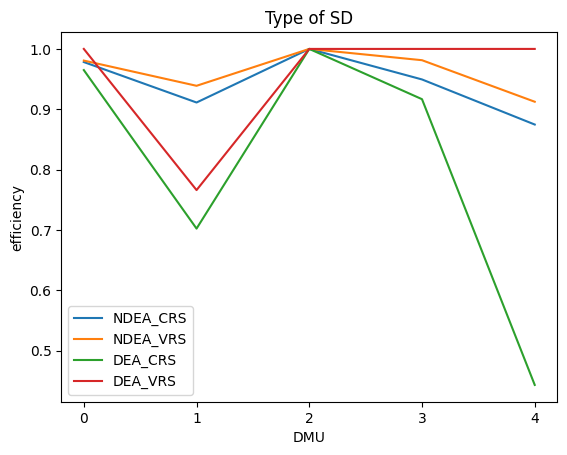

4/5[0, 1, 2, 3, 4] {0: {0: 138.0, 1: 138.0, 2: 138.0}, 1: {0: 93.0, 1: 93.0, 2: 93.0}, 2: {0: 26.0, 1: 26.0, 2: 26.0}, 3: {0: 61.0, 1: 61.0, 2: 61.0}, 4: {0: 96.0, 1: 96.0, 2: 96.0}} {0: {0: 7.0, 1: 10.0, 2: 6.0}, 1: {0: 6.0, 1: 7.0, 2: 6.0}, 2: {0: 9.0, 1: 9.0, 2: 9.0}, 3: {0: 7.0, 1: 9.0, 2: 5.0}, 4: {0: 8.0, 1: 9.0, 2: 7.0}}
model_CRS_result [0.854, 0.847, 1.0, 0.916, 0.864]
model_VRS_result [0.958, 0.924, 1.0, 0.923, 0.866]
CRS_result [0.209, 0.217, 1.0, 0.426, 0.271]
VRS_result [1.0, 0.28, 1.0, 0.426, 0.271]


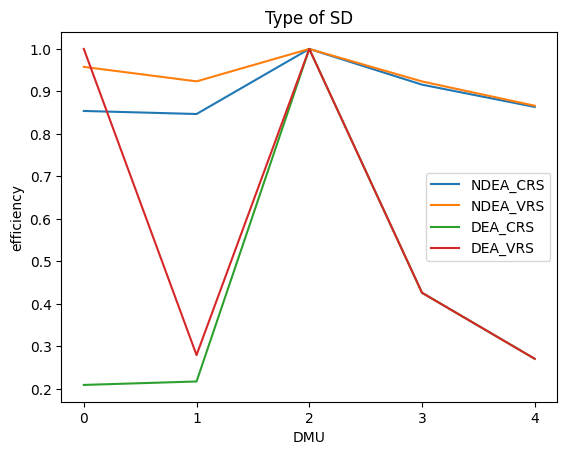

5/5[0, 1, 2, 3, 4] {0: {0: 85.0, 1: 85.0, 2: 85.0}, 1: {0: 123.0, 1: 123.0, 2: 123.0}, 2: {0: 161.0, 1: 161.0, 2: 161.0}, 3: {0: 66.0, 1: 66.0, 2: 66.0}, 4: {0: 51.0, 1: 51.0, 2: 51.0}} {0: {0: 5.0, 1: 9.0, 2: 10.0}, 1: {0: 5.0, 1: 6.0, 2: 9.0}, 2: {0: 8.0, 1: 8.0, 2: 10.0}, 3: {0: 8.0, 1: 8.0, 2: 10.0}, 4: {0: 6.0, 1: 7.0, 2: 10.0}}
model_CRS_result [0.949, 0.871, 0.881, 0.998, 0.998]
model_VRS_result [0.996, 0.972, 0.881, 0.998, 1.0]
CRS_result [0.771, 0.373, 0.41, 1.0, 1.0]
VRS_result [1.0, 0.415, 0.41, 1.0, 1.0]


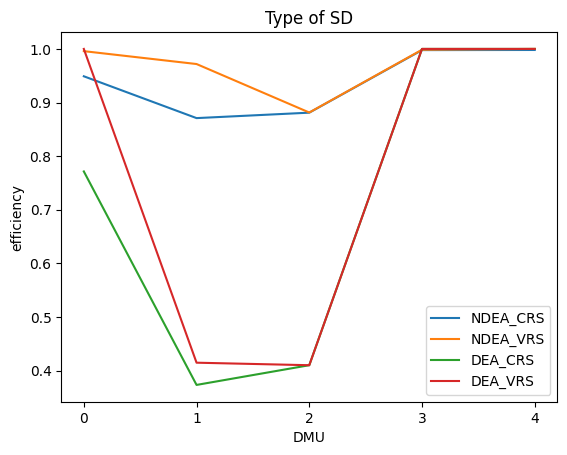

In [108]:
def rounding(a_list, dit=3):
    return list(map(lambda x: round(x, dit), a_list))

# Setting

passing_dataset = []
passing_result = {}
total = 5
epsilon = 0.001

setting_type = "SD"
# random generate the pass dataset
while len(passing_dataset) < total:
    idx = len(passing_dataset)

    # model_result, label = single_model(temp:=dataset_generate_trend(N=5, type="DD", input_idx=0))
    model_CRS_result, label_CRS = single_CRS_model(temp:=dataset_generate(N=5, type=setting_type, input_idx=0))
    model_VRS_result, label_VRS = single_VRS_model(temp)
    # print(temp)
    # print(model_result)
    
    if all(x == True for x in label_CRS +label_VRS):
        print(f"\r{idx+1}/{total}", end='')
        CRS_result = single_CRS(temp)
        VRS_result = single_VRS(temp)

        # store the results
        passing_dataset.append(temp)
        passing_result[idx] = {}
        passing_result[idx]["model_CRS"] = rounding(model_CRS_result)
        passing_result[idx]["model_VRS"] = rounding(model_VRS_result)
        passing_result[idx]["CRS"]   = rounding(CRS_result)
        passing_result[idx]["VRS"]   = rounding(VRS_result)

        print(temp[0], temp[1], temp[2])
        print('model_CRS_result', rounding(model_CRS_result))
        print('model_VRS_result', rounding(model_VRS_result))
        print('CRS_result', rounding(CRS_result))
        print('VRS_result', rounding(VRS_result))

        result = {'NDEA_CRS':rounding(model_CRS_result),
                  'NDEA_VRS': rounding(model_VRS_result),
                  'DEA_CRS': rounding(CRS_result),
                  "DEA_VRS": rounding(VRS_result)
        }
        rusult_name = ['model_CRS_result','model_VRS_result', 'CRS_result', 'VRS_result']
        

        # print(rusult_name)
        plt.plot(model_CRS_result, label="NDEA_CRS")
        plt.plot(model_VRS_result, label="NDEA_VRS")
        plt.plot(CRS_result, label="DEA_CRS")
        plt.plot(VRS_result, label="DEA_VRS")
        plt.xlabel('DMU')
        
        plt.ylabel('efficiency')
        plt.xticks([0,1,2,3,4])
        # plt.xticks(model_CRS_result, ['1', '2','3', '4'], rotation ='vertical') 
        plt.legend()
        plt.title(f"Type of {setting_type}")
        plt.show()
        plt.close()

        # plot_lines(result,
        #            rusult_name=rusult_name,
        #            setting_type=setting_type)


# store the result to txt or other files
# passing_dataset

In [49]:
# X =  {0: {0: 84.0, 1: 84.0, 2: 84.0}, 
# 1: {0: 161.0, 1: 161.0, 2: 161.0}, 
# 2: {0: 83.0, 1: 83.0, 2: 83.0}, 
# 3: {0: 44.0, 1: 44.0, 2: 44.0}, 
# 4: {0: 151.0, 1: 151.0, 2: 151.0}}
# Y =  {0: {0: 7.0, 1: 8.0, 2: 7.0}, 
# 1: {0: 6.0, 1: 9.0, 2: 10.0}, 
# 2: {0: 5.0, 1: 7.0, 2: 5.0}, 
# 3: {0: 6.0, 1: 8.0, 2: 7.0}, 
# 4: {0: 7.0, 1: 7.0, 2: 8.0}}


In [ ]:
print(f"\r{idx+1}/{total}", end='')
CRS_result = single_CRS(temp)
VRS_result = single_VRS(temp)

# store the results
passing_dataset.append(temp)
passing_result[idx] = {}
passing_result[idx]["model_CRS"] = rounding(model_CRS_result)
passing_result[idx]["model_VRS"] = rounding(model_VRS_result)
passing_result[idx]["CRS"]   = rounding(CRS_result)
passing_result[idx]["VRS"]   = rounding(VRS_result)

print(rounding(model_result), rounding(CRS_result))

plot_fig(model_result, CRS_result)

In [121]:
# passing_dataset = []
# passing_result = {}
# passing_result["model"] = {}
# passing_result["CRS"] = {}
# total = 4
# epsilon = 0.001

# while len(passing_dataset) < total:
#     idx = len(passing_dataset)

#     model_result, label = single_model(temp:=dataset_generate(N=5, type="DD", input_idx=0))
#     if all(x == True for x in label):
#         print(f"\r{idx}/{total}", end='')
#         CRS_result = CRS(temp)
#         # store the results
#         passing_dataset.append(temp)
#         passing_result["model"][idx] = model_result
#         passing_result["CRS"][idx]= CRS_result

# # store the result to txt or other files
# passing_dataset

In [122]:
passing_result

{0: {'model': [0.891, 0.898, 0.934, 0.937, 0.867],
  'CRS': [0.826, 1.0, 1.0, 1.0, 0.56]},
 1: {'model': [0.908, 0.929, 0.962, 0.976, 0.992],
  'CRS': [0.82, 0.775, 1.0, 1.0, 1.0]},
 2: {'model': [0.926, 0.93, 0.997, 0.87, 0.903],
  'CRS': [1.0, 1.0, 1.0, 1.0, 0.698]},
 3: {'model': [0.968, 0.87, 0.861, 0.935, 0.94],
  'CRS': [1.0, 0.545, 0.509, 0.863, 1.0]}}

In [123]:
pd.DataFrame.from_dict(passing_result, orient="index")

,model,CRS
0,"[0.891, 0.898, 0.934, 0.937, 0.867]","[0.826, 1.0, 1.0, 1.0, 0.56]"
1,"[0.908, 0.929, 0.962, 0.976, 0.992]","[0.82, 0.775, 1.0, 1.0, 1.0]"
2,"[0.926, 0.93, 0.997, 0.87, 0.903]","[1.0, 1.0, 1.0, 1.0, 0.698]"
3,"[0.968, 0.87, 0.861, 0.935, 0.94]","[1.0, 0.545, 0.509, 0.863, 1.0]"


In [ ]:
pd.DataFrame.from_dict(passing_result, orient="index")

## Test part

In [148]:
# DMU = [0, 1, 2, 3, 4]

# X = {0: {0: 1, 1: 1, 2: 1},
#      1: {0: 2, 1: 2, 2: 2},
#      2: {0: 3, 1: 3, 2: 3},
#      3: {0: 4, 1: 4, 2: 4},
#      4: {0: 5, 1: 5, 2: 5}}

# Y = {0: {0: 100, 1: 100, 2: 100},
#      1: {0: 100, 1: 100, 2: 100},
#      2: {0: 100, 1: 100, 2: 100},
#      3: {0: 100, 1: 100, 2: 100},
#      4: {0: 100, 1: 100, 2: 100}}

# epsilon = 0.001

# I = len(X[DMU[0]])
# O = len(Y[DMU[0]])
# I, O

(3, 3)

1/2
model_result [0.866, 0.933, 0.893, 0.943, 0.852]
CRS_result [1.0, 1.0, 1.0, 1.0, 0.476]


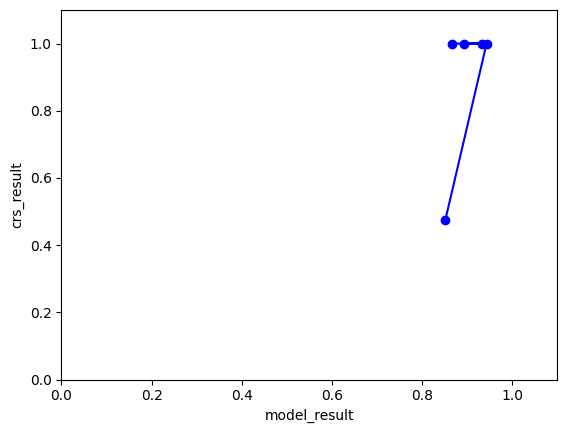

2/2
model_result [0.827, 0.869, 0.937, 0.926, 0.971]
CRS_result [0.458, 0.777, 1.0, 1.0, 1.0]


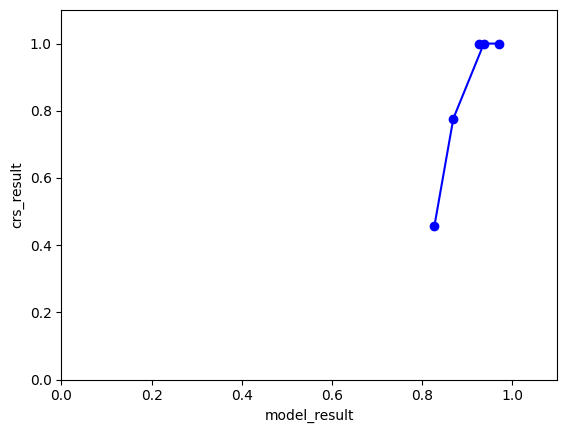

In [167]:
temp_list = []

epsilon = 0.001
total = 2
while len(temp_list) < total:
    idx = len(temp_list)

    model_result, label = single_model(temp:=dataset_generate(N=5, type="DD", input_idx=0))
    if all(x == True for x in label):
        print(f"\r{idx+1}/{total}")
        CRS_result = single_CRS(temp)
        
        # store the results
        print("model_result", list(map(lambda x : round(x,3), model_result)))
        print("CRS_result", list(map(lambda x : round(x,3), CRS_result)))
        plot_fig(model_result, CRS_result)
        temp_list.append(model_result)

# store the result to txt or other files
# passing_dataset